# Amplifier

In [5]:
import os
import control
import transform
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

duration = 26.84e-3
delays = np.linspace(0, duration, 300)

os.makedirs('../dataset/amplifier', exist_ok=True)
os.makedirs('../figure/amplifier', exist_ok=True)

In [ ]:
scope = control.MSOX6004A('172.22.22.30')
fngen = control.FG33250A2('172.22.22.36')

scope.holla(), fngen.holla()

## Measurement

Insert the external trigger signal to the back of the Agilent 33220A function generator and connect its output with the external trigger input of the oscilloscope. Let the oscilloscope trigger on falling edge and set the time scale to 20 us. The function generator should be configured to output pulse signals with period of 30 ms.

The output of the horizontal DDS is connected to the horizontal amplifier. The DDS driver is configured with inverse sinc filter turned off in the subsequent experiments.

The output of the horizontal amplifier is connected to the following attentuators to not destory the oscillscope:

1. 1 dB
2. 3 dB
3. 6 dB
4. 10 dB
5. 10 dB

With the damping power increasing towards the oscilloscope such that the heat is distributed more evenly.

In [2]:
control.aod_h(frequency=[80e6, 120e6], amplitude=np.ones(1024), duration=duration)

data = []

for t in delays:
    fngen.width(t)
    
    data.append((t, scope.capture()))

for (t, df) in data:
    df.to_hdf('../dataset/amplifier/horizontal.h5', str(t), format='table', complevel=9)

Now connect the output of the horizontal DDS to the input of the vertical amplifier. Then connect the output of the vertical amplifier through the same attentuator configurator as before with the oscilloscope.

In [3]:
control.aod_h(frequency=[80e6, 120e6], amplitude=np.ones(1024), duration=duration)

data = []

for t in delays:
    fngen.width(t)
    
    data.append((t, scope.capture()))

for (t, df) in data:
    df.to_hdf('../dataset/amplifier/vertical.h5', str(t), format='table', complevel=9)

Now connect the vertical DDS with the oscillscope output. Check again that the DDS driver has the inverse sinc filter turned off.

## Evaluation

We are interested in the signal amplitude in dependence of the frequency. Thus we will do a FFT on each segment to identify the dominant frequency and take the maximum voltage as amplitude. Then we compare the different configuration.

In [15]:
data = {
    'horizontal': {},
    'vertical': {},
}

for run, frames in data.items():
    for d in delays:
        frames[d] = pd.read_hdf(f'../dataset/amplifier/{run}.h5', str(d))
        
frames = data['source'] = {}
        
for d in delays:
    frames[d] = pd.read_hdf('../dataset/synthesizer/horizontal-sinc-off.h5', str(d))

In [16]:
data_f_to_A = {}

for key, run in data.items():
    d = data_f_to_A[key] = []

    for t, df in run.items():
        f, P = transform.fft(df.time, df.voltage)
        
        d.append((f[P.argmax()], df.voltage.max()))

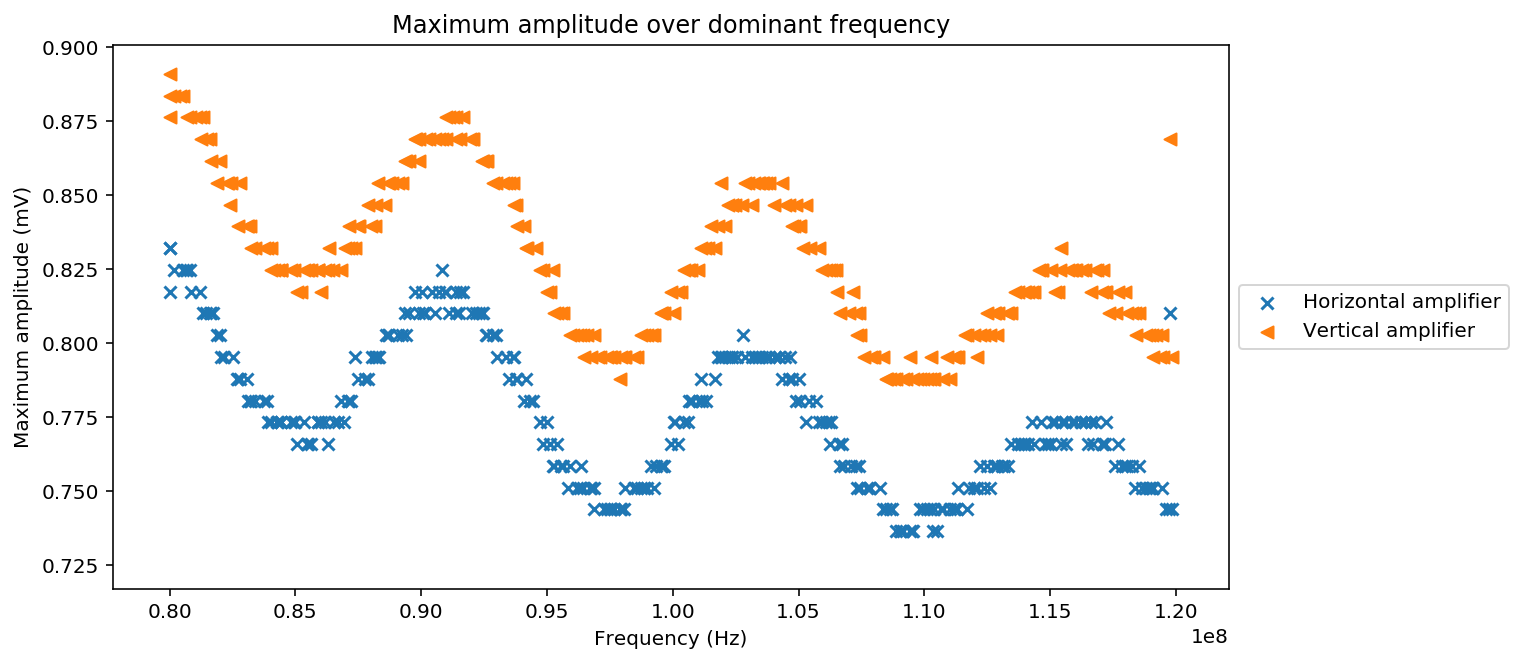

In [29]:
fig = plt.figure(figsize=(10, 5))

f, A = zip(*data_f_to_A['horizontal'])
plt.scatter(f, A, label='Horizontal amplifier', marker='x')

f, A = zip(*data_f_to_A['vertical'])
plt.scatter(f, A, label='Vertical amplifier', marker='<')

plt.title('Maximum amplitude over dominant frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Maximum amplitude (mV)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig('../figure/amplifier/spectrum.pdf', bbox_inches='tight')
plt.show()

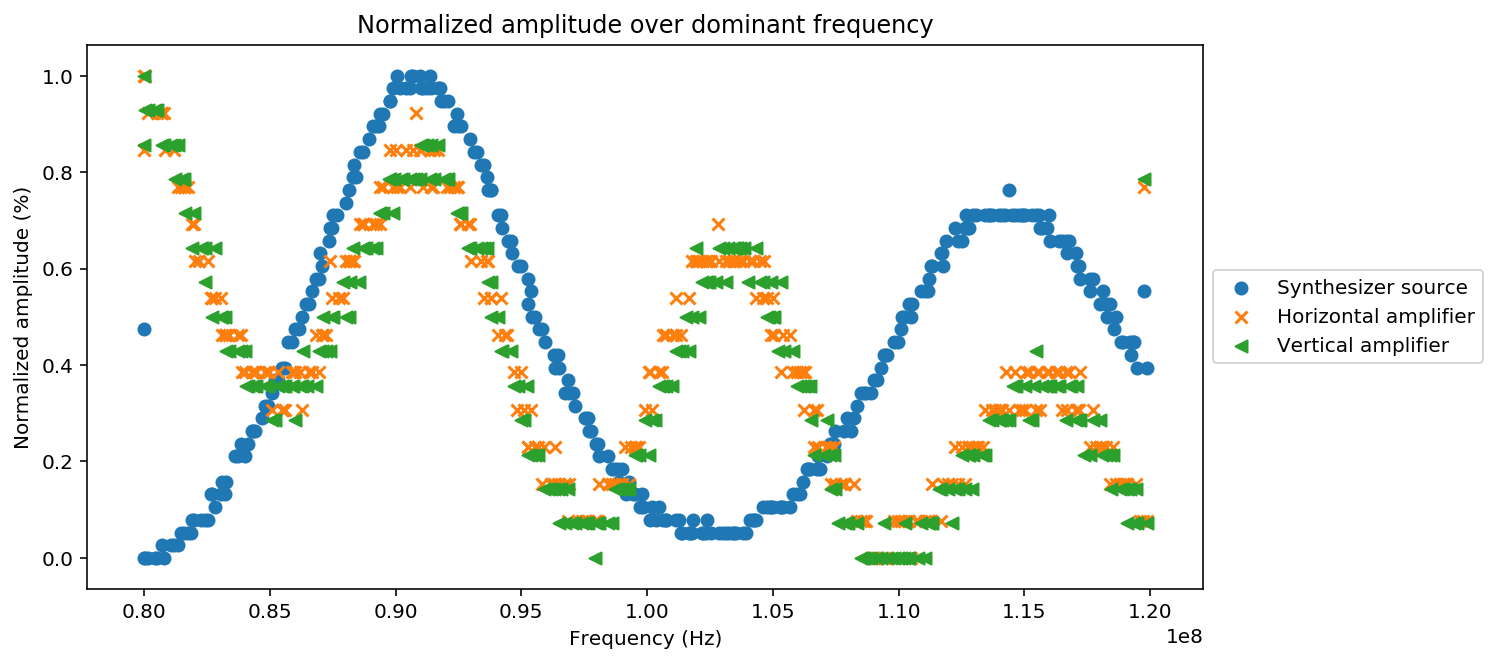

In [28]:
fig = plt.figure(figsize=(10, 5))

fs, As = zip(*data_f_to_A['source'])
fh, Ah = zip(*data_f_to_A['horizontal'])
fv, Av = zip(*data_f_to_A['vertical'])

#vmin = np.min([np.min(As), np.min(Ah), np.min(Av)])
#vmax = np.max([np.max(As), np.max(Ah), np.max(Av)])

As = (As - np.min(As)) / (np.max(As) - np.min(As))
Ah = (Ah - np.min(Ah)) / (np.max(Ah) - np.min(Ah))
Av = (Av - np.min(Av)) / (np.max(Av) - np.min(Av))

plt.scatter(fs, As, label='Synthesizer source', marker='o')
plt.scatter(fh, Ah, label='Horizontal amplifier', marker='x')
plt.scatter(fv, Av, label='Vertical amplifier', marker='<')

plt.title('Normalized amplitude over dominant frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized amplitude (%)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig('../figure/amplifier/source.pdf', bbox_inches='tight')
plt.show()

## Conclusion

The amplifiers differ by a constant offset, further they introduce another resonance on top of the DDS resonance.